In [1]:
import pandas as pd
import numpy as np
import joblib
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay,f1_score
from scipy.stats import randint, uniform
from sklearn.cluster import KMeans

In [2]:
# --- 1. Load Processed Data ---

X_train = pd.read_csv('X_train_processed.csv')

X_test = pd.read_csv('X_test_processed.csv')


y_train = pd.read_csv('y_train_encoded.csv').squeeze("columns") # ravel() converts them into 1d array but .squeeze("columns") converts into series
y_test = pd.read_csv('y_test_encoded.csv').squeeze("columns")



In [3]:
X_train

,num__admission_type_id,num__discharge_disposition_id,num__admission_source_id,num__time_in_hospital,num__num_lab_procedures,num__num_procedures,num__num_medications,num__number_outpatient,num__number_emergency,num__number_inpatient,...,cat__diag_2_group_Other,cat__diag_2_group_Respiratory,cat__diag_3_group_Circulatory,cat__diag_3_group_Diabetes,cat__diag_3_group_Digestive,cat__diag_3_group_Injury,cat__diag_3_group_Musculoskeletal,cat__diag_3_group_Neoplasms,cat__diag_3_group_Other,cat__diag_3_group_Respiratory
0,-0.709619,2.706125,0.310371,1.883770,0.251086,-0.787127,0.245521,-0.291807,-0.225864,-0.501975,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2.055526,-0.513976,2.774348,-0.130345,-1.377124,-0.787127,-0.863274,0.494999,-0.225864,-0.501975,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.018333,-0.513976,-1.168015,-0.801716,-0.054203,-0.787127,-0.986473,-0.291807,-0.225864,0.289154,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.018333,-0.513976,-1.168015,-1.137402,-2.038584,-0.787127,-1.356072,-0.291807,-0.225864,-0.501975,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.672953,3.463796,0.063974,-1.137402,-0.613901,0.970576,-0.247277,-0.291807,-0.225864,0.289154,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81405,0.672953,-0.513976,-1.168015,-1.137402,-0.359493,2.728280,-0.863274,-0.291807,-0.225864,-0.501975,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
81406,-0.709619,-0.513976,0.310371,-0.801716,0.149323,-0.787127,-1.356072,-0.291807,-0.225864,-0.501975,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
81407,-0.709619,-0.513976,0.310371,-1.137402,-1.275361,-0.787127,-0.986473,-0.291807,-0.225864,0.289154,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
81408,-0.018333,-0.513976,-1.168015,2.890828,1.217835,0.384675,0.368721,-0.291807,-0.225864,-0.501975,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [42]:
X_test.shape

(20353, 84)

In [35]:
y_test

0        2
1        0
2        1
3        1
4        1
        ..
20348    2
20349    0
20350    1
20351    2
20352    2
Name: readmitted_encoded, Length: 20353, dtype: int64

In [ ]:
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score

# best_k = None
# best_score = -1

# for k in range(51, 52):
#     kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
#     labels = kmeans.fit_predict(X_train)
#     score = silhouette_score(X_train, labels)
#     print(f"k={k}, silhouette={score:.4f}")
    
#     if score > best_score:
#         best_k = k
#         best_score = score

# print(f"\n✅ Best k based on silhouette score: {best_k} (score={best_score:.4f})")


k=51, silhouette=0.0906

✅ Best k based on silhouette score: 51 (score=0.0906)


In [ ]:
# Yes, you can train KMeans on a pandas DataFrame,
# but internally it always converts it to a NumPy array before fitting.

In [ ]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
train_cluster_labels = kmeans.fit_predict(X_train) # xtrain is dataframe but internally it gets converted as array
test_cluster_labels = kmeans.predict(X_test)

print("\nCluster distribution (train):", np.bincount(train_cluster_labels))
print("Cluster distribution (test):", np.bincount(test_cluster_labels))


Cluster distribution (train): [21002 18522 34884  1237  5765]
Cluster distribution (test): [5358 4696 8613  302 1384]


In [88]:
rf_param_dist = {
    'n_estimators': randint(200, 800),
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': randint(2, 15),
    'min_samples_leaf': randint(1, 8),
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample']
}


# XGBoost parameter distributions
xgb_param_dist = {
    'n_estimators': randint(200, 800),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.5)
}




--- Cluster 0 ---


c:\Users\chval\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [01:49:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


 Best Model: RandomForest | F1: 0.509, Acc: 0.523


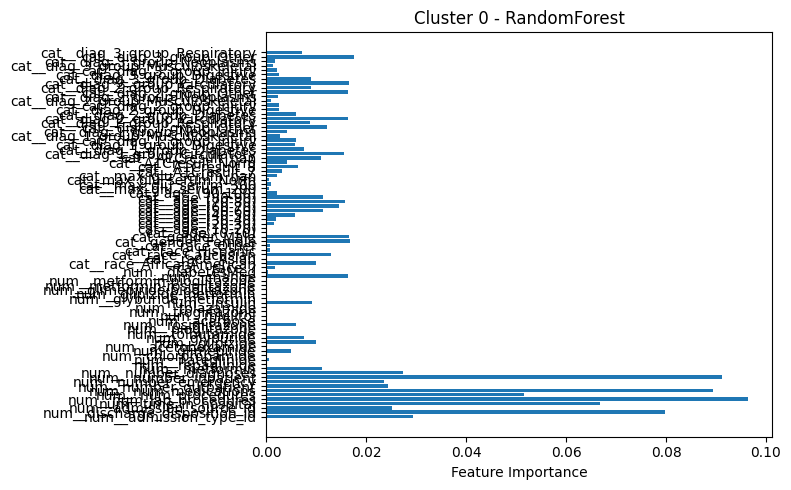


--- Cluster 1 ---


c:\Users\chval\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [02:01:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


 Best Model: RandomForest | F1: 0.590, Acc: 0.616


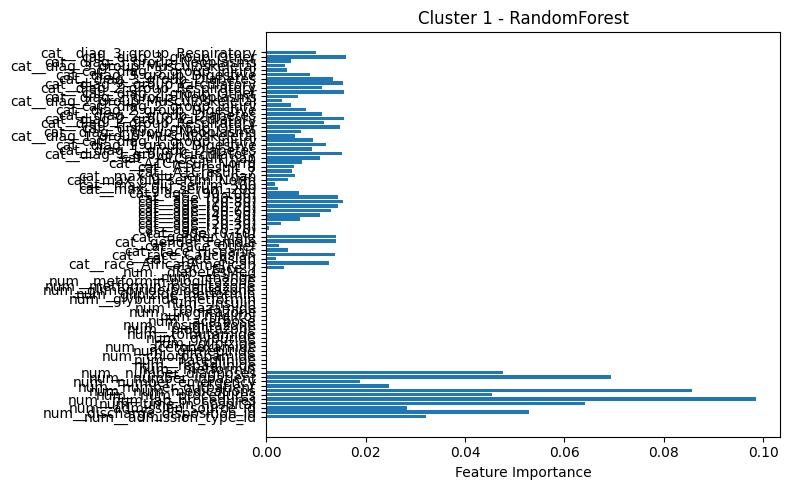


--- Cluster 2 ---


c:\Users\chval\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [02:29:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


 Best Model: RandomForest | F1: 0.558, Acc: 0.575


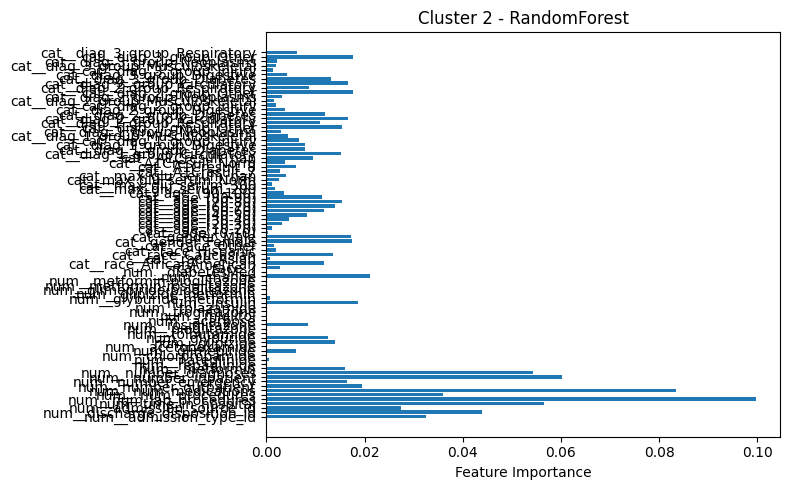


--- Cluster 3 ---


c:\Users\chval\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [02:30:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


 Best Model: XGBoost | F1: 0.449, Acc: 0.474


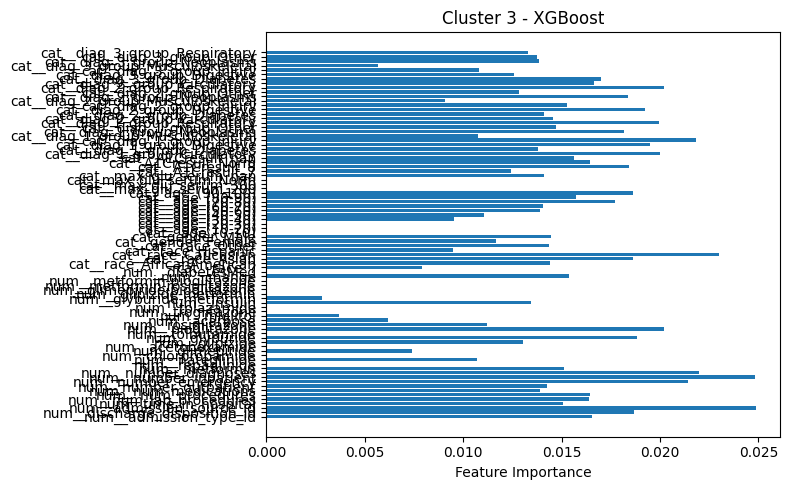


--- Cluster 4 ---


c:\Users\chval\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [02:33:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


 Best Model: RandomForest | F1: 0.556, Acc: 0.568


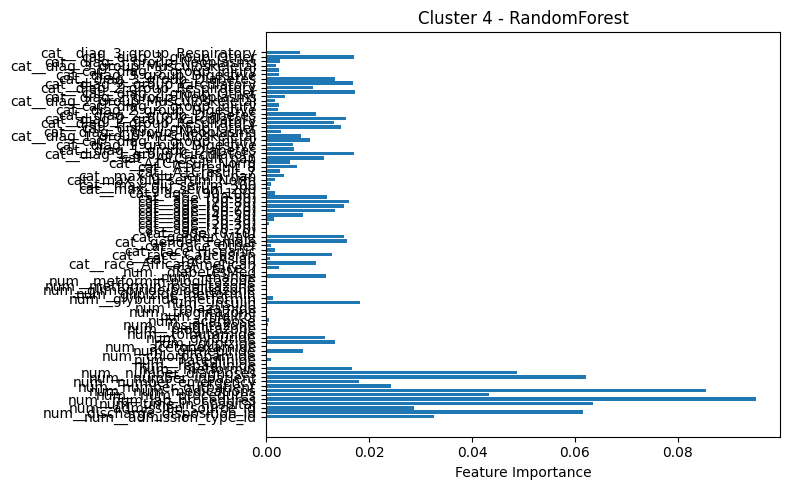

In [ ]:

results = {}
best_models = {}
X_train.columns = [str(c).replace('[', '(').replace(']', ')').replace('<', '').replace('>', '') for c in X_train.columns]
X_test.columns = [str(c).replace('[', '(').replace(']', ')').replace('<', '').replace('>', '') for c in X_test.columns]
# we use this because since we used transformer 
# If you used something like pd.get_dummies() or ColumnTransformer,
# it can generate column names such as:

# gender_[Male]
# age_<30


# which XGBoost doesn’t accept directly.



for cluster in range(n_clusters):
    print(f"\n--- Cluster {cluster} ---")

    # Separate data for this cluster
    X_cluster_train = X_train.iloc[train_cluster_labels == cluster] # it is still as dataframe only
    y_cluster_train = y_train.iloc[train_cluster_labels == cluster]
    X_cluster_test = X_test.iloc[test_cluster_labels == cluster]
    y_cluster_test = y_test.iloc[test_cluster_labels == cluster]
    # we need iloc here because in cement prediction it was array but here it is dataframe so we have to go row by row
    if len(X_cluster_train) < 5 or len(np.unique(y_cluster_train)) < 2:
        print(f"Skipping Cluster {cluster} (too few samples or single class)")
        continue

    # --- Random Forest ---
    rf = RandomForestClassifier(random_state=42)
    rf_random = RandomizedSearchCV(rf, rf_param_dist, n_iter=50, cv=5, scoring='f1_weighted', n_jobs=-1, random_state=42)
    rf_random.fit(X_cluster_train, y_cluster_train)
    best_rf = rf_random.best_estimator_

    y_pred_rf = best_rf.predict(X_cluster_test)
    rf_acc = accuracy_score(y_cluster_test, y_pred_rf)
    rf_f1 = f1_score(y_cluster_test, y_pred_rf, average='weighted')

    # --- XGBoost ---
    xgb = XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False)
    xgb_random = RandomizedSearchCV(xgb, xgb_param_dist, n_iter=50, cv=5, scoring='f1_weighted', n_jobs=-1, random_state=42)

    xgb_random.fit(X_cluster_train, y_cluster_train)
    best_xgb = xgb_random.best_estimator_

    y_pred_xgb = best_xgb.predict(X_cluster_test)
    xgb_acc = accuracy_score(y_cluster_test, y_pred_xgb)
    xgb_f1 = f1_score(y_cluster_test, y_pred_xgb, average='weighted')

    # --- Pick best model ---
    if xgb_f1 > rf_f1:
        best_models[cluster] = best_xgb
        best_name, best_f1, best_acc = "XGBoost", xgb_f1, xgb_acc
    else:
        best_models[cluster] = best_rf
        best_name, best_f1, best_acc = "RandomForest", rf_f1, rf_acc

    results[f"Cluster_{cluster}"] = {"Model": best_name, "Accuracy": best_acc, "Weighted F1": best_f1}
    print(f" Best Model: {best_name} | F1: {best_f1:.3f}, Acc: {best_acc:.3f}")

    # --- Feature Importance plot per cluster ---
    importances = best_models[cluster].feature_importances_
    plt.figure(figsize=(8, 5))
    plt.barh(X_train.columns, importances)
    plt.xlabel("Feature Importance")
    plt.title(f"Cluster {cluster} - {best_name}")
    plt.tight_layout()
    plt.show()

In [90]:
# --- 5. Save models and KMeans ---
joblib.dump(kmeans, "kmeans.pkl")
joblib.dump(best_models, "cluster_models.pkl")
print("\n All cluster models and KMeans saved successfully!")


 All cluster models and KMeans saved successfully!


In [91]:
type(X_train)
from sklearn.compose import ColumnTransformer

| Method          | What it does                              | When to use           | Updates centroids? |
| :-------------- | :---------------------------------------- | :-------------------- | :----------------- |
| `fit()`         | Learns centroids only                     | During training       | ✅ Yes              |
| `predict()`     | Assigns clusters using existing centroids | On new/test data      | ❌ No               |
| `fit_predict()` | Does both (fit + predict) on same data    | For training set only | ✅ Yes              |


In [92]:
sample = pd.DataFrame(X_test.iloc[0].values.reshape(1, -1), columns=X_test.columns)

In [93]:
kmeans.predict(sample)

array([0])

In [ ]:
def predict_new(sample):
    # Convert sample to DataFrame with same column names
    if isinstance(sample, np.ndarray):
        sample = pd.DataFrame(sample.reshape(1, -1), columns=X_test.columns)
        # since xtest is nd array so we have to convert it into dataframe
    elif isinstance(sample, pd.Series):
        sample = sample.to_frame().T

    # Predict cluster
    cluster = kmeans.predict(sample)[0]
    model = best_models[cluster]

    # Predict final label
    return model.predict(sample)[0]


In [95]:
type(X_train.iloc[0].values)

numpy.ndarray

In [96]:
# Example: Predict a specific row by index
row_index = 19  # choose any index you like
sample_raw = X_test.iloc[row_index].values  # get raw feature values
prediction = predict_new(sample_raw)
print(f"Prediction for row {row_index}: {prediction:.2f} class")

Prediction for row 19: 2.00 class


In [ ]:
import pandas as pd
import joblib

def predict_clusterwise(sample):
    """
    Predict diabetes outcomes cluster-wise using pre-saved models.

    Args:
        csv_path (str): Path to X_test_processed.csv
        kmeans_path (str): Path to saved KMeans model (kmeans.pkl)
        cluster_models_path (str): Path to dictionary of trained models (cluster_models.pkl)

    Returns:
        pd.DataFrame: DataFrame with cluster and prediction columns
    """

     # Convert sample to DataFrame with same column names
    if isinstance(sample, np.ndarray):
        sample = pd.DataFrame(sample.reshape(1, -1), columns=X_test.columns)
        # since xtest is nd array so we have to convert it into dataframe
    elif isinstance(sample, pd.Series):
        sample = sample.to_frame().T


    # Load data and models
   
    kmeans = joblib.load("kmeans.pkl")
    cluster_models = joblib.load("cluster_models.pkl")

    # Predict cluster
    cluster = kmeans.predict(sample)[0]
    model = cluster_models[cluster]

    # Predict final label
    return model.predict(sample)[0]





In [6]:
X_test = pd.read_csv("X_test_processed.csv")
# Example: Predict a specific row by index
row_index = 19  # choose any index you like
sample_raw = X_test.iloc[row_index].values  # get raw feature values
prediction = predict_clusterwise(sample_raw)
print(f"Prediction for row {row_index}: {prediction:.2f} class")

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- cat__A1Cresult_>7
- cat__A1Cresult_>8
- cat__age_[0-10)
- cat__age_[10-20)
- cat__age_[20-30)
- ...
Feature names seen at fit time, yet now missing:
- cat__A1Cresult_7
- cat__A1Cresult_8
- cat__age_(0-10)
- cat__age_(10-20)
- cat__age_(20-30)
- ...


In [9]:
import pandas as pd
import numpy as np
import joblib

# Load reference columns
X_test = pd.read_csv("X_test_processed.csv")

def predict_clusterwise(sample, X_columns):
    """Predict diabetes outcomes cluster-wise using pre-saved models."""

    # Convert sample to DataFrame
    if isinstance(sample, np.ndarray):
        sample = pd.DataFrame(sample.reshape(1, -1), columns=X_columns)
    elif isinstance(sample, pd.Series):
        sample = sample.to_frame().T

    # Load models
    kmeans = joblib.load("kmeans.pkl")
    cluster_models = joblib.load("cluster_models.pkl")

    # Predict cluster (convert to numpy to avoid name mismatch)
    cluster = kmeans.predict(sample.values)[0]

    # Get corresponding model
    if cluster not in cluster_models:
        raise ValueError(f"No trained model found for cluster {cluster}")

    model = cluster_models[cluster]

    # Predict final label
    prediction = model.predict(sample.values)[0]
    return cluster, prediction


# Example usage
row_index = 20
sample_raw = X_test.iloc[row_index].values

cluster, prediction = predict_clusterwise(sample_raw, X_test.columns)
print(f"Row {row_index} belongs to Cluster {cluster} → Prediction: {prediction} class")


Row 20 belongs to Cluster 1 → Prediction: 1 class


c:\Users\chval\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
c:\Users\chval\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
